### Installing required libraries

In [ ]:
pip install neuralforecast==1.7.3 numpy==1.24.4  scikit-learn==1.3.2 matplotlib==3.7.1 pandas==2.1.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from ray import tune
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NBEATS, NHITS

Create calculate error metrics function which helps in assessing the performance of the trained model

In [ ]:

def calculate_error_metrics(actual, predicted, num_predictors=1):
    # convert inputs are numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)
    # Number of observations
    n = len(actual)
    # Calculate MSE
    mse = mean_squared_error(actual, predicted)
    # Calculate RMSE
    rmse = np.sqrt(mse)
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted)
    # Calculate R-squared
    r2 = r2_score(actual, predicted)
    # Calculate Adjusted R-squared
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    print(f'MSE : {mse}')
    print(f'RMSE : {rmse}')
    print(f'MAPE : {mape}')
    print(f'r2 : {r2}')
    print(f'adjusted_r2 : {adjusted_r2}')

Load **AirPassenger** data set

In [ ]:
# To load local csv  > modify to the right path where the file is present
#Y_df = pd.read_csv('AirPassengersDataset.csv')
#Y_df = Y_df.reset_index(drop=True)

from neuralforecast.utils import AirPassengersDF
Y_df = AirPassengersDF
Y_df = Y_df.reset_index(drop=True)
Y_df.head()


,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


Split data into **train** and **test**

In [ ]:
train_data = Y_df.head(132)
test_data = Y_df.tail(12)

Lets initialize and training model (**NBEATS**) and define its hyperparameters.

In [ ]:
horizon = 12
models = [NBEATS(input_size=2 * horizon, h=horizon, max_steps=50)]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=train_data)

INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.10/dist-packages/neuralforecast/common/_base_model.py:346: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
900       Non-trainable params
2.4 M     Total params
9.789     Total estimated

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=50` reached.


Predict for the next defined horizon

In [ ]:
Y_hat_df = nf.predict().reset_index()
Y_hat_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,unique_id,ds,NBEATS
0,1.0,1960-01-31,427.045990
1,1.0,1960-02-29,448.289337
2,1.0,1960-03-31,453.882721
3,1.0,1960-04-30,455.047668
4,1.0,1960-05-31,496.515900


Measure the models accuracy

In [ ]:
calculate_error_metrics(test_data[['y']],Y_hat_df['NBEATS'])

MSE : 1111.5928955078125
RMSE : 33.34056091308594
MAPE : 0.06422501802444458
r2 : 0.799332357382532
adjusted_r2 : 0.7792655931207852


Visualize the predictions

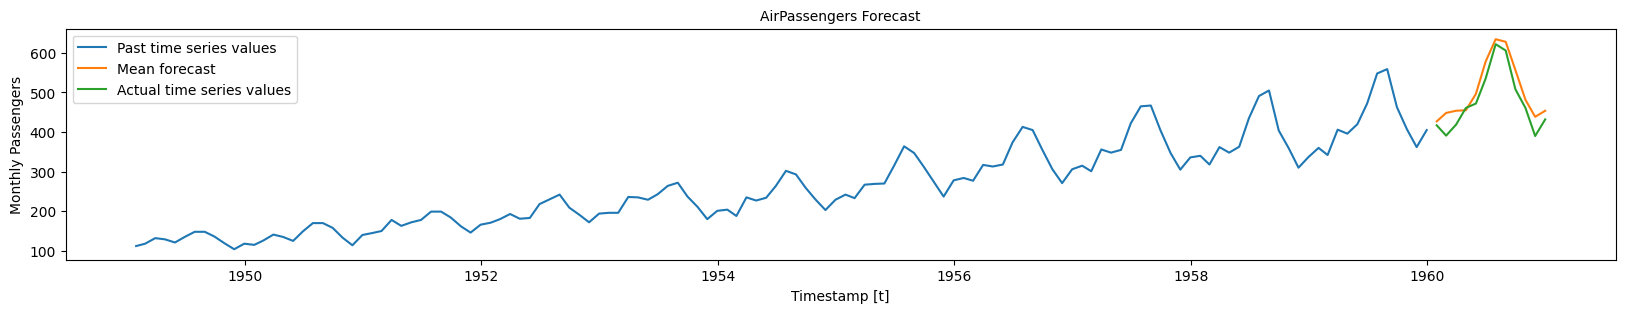

In [ ]:
train_data.set_index('ds',inplace =True)
Y_hat_df.set_index('ds',inplace =True)
test_data.set_index('ds',inplace =True)

plt.figure(figsize=(20, 3))

item_id = "airline_1"
y_past = train_data["y"]
y_pred = Y_hat_df['NBEATS']
y_test = test_data["y"]

plt.plot(y_past, label="Past time series values")
plt.plot(y_pred, label="Mean forecast")
plt.plot(y_test, label="Actual time series values")
plt.title('AirPassengers Forecast', fontsize=10)
plt.ylabel('Monthly Passengers', fontsize=10)
plt.xlabel('Timestamp [t]', fontsize=10)

plt.legend();